In [1]:
# !pip install geopy
# !pip install scikit-opt
import pandas as pd
import numpy as np
from geopy import distance
from sko.GA import GA_TSP
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_excel('task.xlsx')
df.head()

,Порядковый номер объекта,LATITUDE_X,LONGITUDE_Y
0,1,54.994660,60.400282
1,2,54.998998,60.422036
2,3,54.983947,60.360321
3,4,54.983750,60.364172
4,5,54.982138,60.367692


**1. Оценить совокупную дистанцию текущего маршрута. Объекты обслуживаются в порядке указанном в файле.**

In [3]:
def distance_way(df):
    way = 0

    for i in range(df.shape[0] - 1):
        from_object = tuple(df.loc[i, ['LATITUDE_X', 'LONGITUDE_Y']])
        to_object = tuple(df.loc[i + 1, ['LATITUDE_X', 'LONGITUDE_Y']])
        way += distance.distance(from_object, to_object).km

    return round(way, 2)

In [4]:
print(f'Cовокупная дистанция текущего маршрута: {distance_way(df)} км')

Cовокупная дистанция текущего маршрута: 60.76 км


In [5]:
def visial(coords):
    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(12)
    ax.plot(coords[:, 0], coords[:, 1], marker='o', markerfacecolor='b', color='c', linestyle='-')
    plt.show()

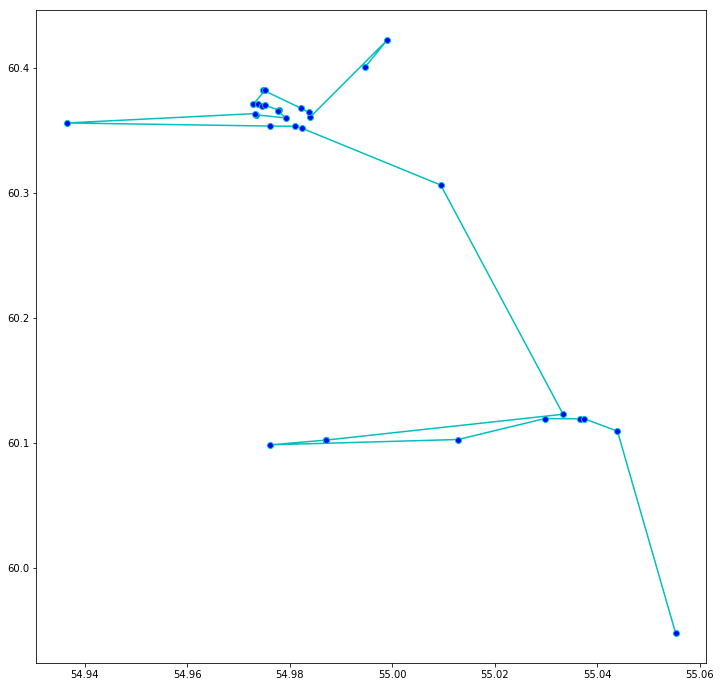

In [6]:
coordinates = np.array(df[['LATITUDE_X','LONGITUDE_Y']])
visial(coordinates)

**2. Построить оптимальный маршрут заезда. Минимизируется совокупное расстояние маршрута. Порядок объектов изменяется по вашему усмотрению**

Задача поиска самого выгодного маршрута (задача коммивояжёра) относится к классу NP-трудных задач. Наш незамкнутый вариант сведем к замкнутому, введя дополнительную вершину с весом ребер равными 0. Для оптимизации применим генетический алгоритм.

In [7]:
def distance_mat(coordinates): # матрица расстояний
    l = len(coordinates)
    arr = np.zeros((l, l))
    for i in range(l):
        for j in range(l):
            arr[i][j] = distance.distance(coordinates[i], coordinates[j]).km
    return arr

In [8]:
distance_matrix = distance_mat(coordinates) # добовляем нулевые веса
distance_matrix = np.insert(distance_matrix, distance_matrix.shape[1], 0, axis=1)
distance_matrix = np.insert(distance_matrix, distance_matrix.shape[0], 0, axis=0)

coordinates_padding = np.append(coordinates, [[0, 0]], axis = 0) # добовляем дополнительную вершину
num_points  = len(coordinates_padding)


def cal_total_distance(routine):
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])

Attempt :0. Distance :[53.27273116]
Attempt :4. Distance :[53.18100495]
Attempt :5. Distance :[52.9088691]


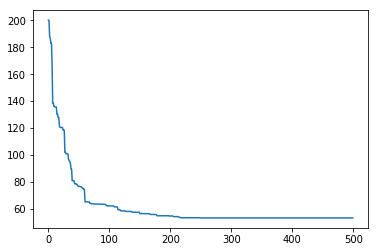

In [9]:
attempts = 10 # чем больше попыток тем лучше результат, но дольше
best_points, best_distance = range(num_points), distance_way(df)

for attempt in (range(attempts)):
    ga_tsp = GA_TSP(func=cal_total_distance, n_dim=num_points, size_pop=50, max_iter=500, prob_mut=1)
    points, distan = ga_tsp.run()
    if distan < best_distance:
        print(f'Attempt :{attempt}. Distance :{distan}')
        best_points, best_distance = points, distan

fig, ax = plt.subplots()
plt.plot(ga_tsp.generation_best_Y)
plt.show()

In [10]:
route = list(best_points) # убираем дополнительную вершину
ind = route.index(len(route) - 1)
route = route[ind + 1:] + route[:ind]
print(route)
print(best_distance)

[16, 15, 14, 17, 13, 12, 11, 10, 9, 8, 7, 5, 6, 1, 0, 4, 3, 2, 18, 19, 20, 25, 22, 24, 23, 26, 27, 21, 28, 29, 30, 31]
[52.9088691]


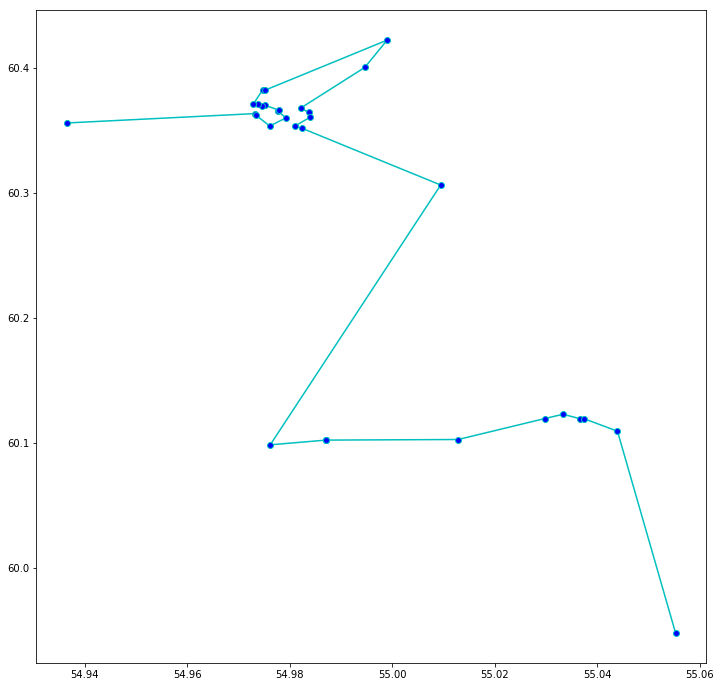

In [11]:
new_coordinates = coordinates_padding[route] # новый маршрут
visial(new_coordinates)

In [12]:
df_new = pd.DataFrame(np.array(df)[route], columns=df.columns, index=range(1, df.shape[0] + 1))
df_new.index.name = 'Новый порядок'
df_new.to_excel("output.xlsx")

In [13]:
df_new = pd.read_excel('output.xlsx')
df_new.head()

,Новый порядок,Порядковый номер объекта,LATITUDE_X,LONGITUDE_Y
0,1,17,54.936532,60.355806
1,2,16,54.973278,60.363311
2,3,15,54.973337,60.362327
3,4,18,54.976092,60.353332
4,5,14,54.979262,60.359855


In [14]:
print(f'Cовокупная дистанция текущего маршрута: {distance_way(df)} км')
print(f'Cовокупная дистанция оптимального маршрута: {distance_way(df_new)} км')

Cовокупная дистанция текущего маршрута: 60.76 км
Cовокупная дистанция оптимального маршрута: 52.91 км


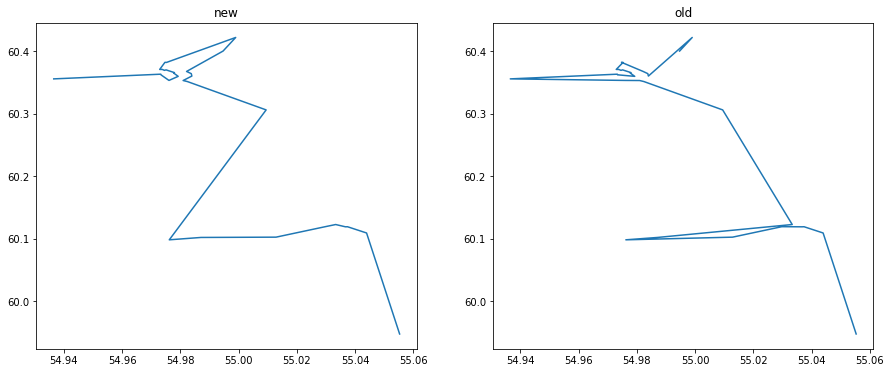

In [15]:
fig , (ax1, ax2) = plt.subplots(1, 2, figsize = ( 15 , 6 )) 
new = np.array(df_new[['LATITUDE_X','LONGITUDE_Y']])
old = np.array(df[['LATITUDE_X','LONGITUDE_Y']])

ax1.set_title('new')
ax1.plot(new[:, 0], new[:, 1])

ax2.set_title('old')
ax2.plot(old[:, 0], old[:, 1])
plt.show()